In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
directory_root = "PlantVillage/"
print(len(listdir(directory_root)))

11


In [3]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}"
        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [4]:
img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))

                                          image_path  \
0  PlantVillage//Pepper__bell___Bacterial_spot/00...   
1  PlantVillage//Pepper__bell___Bacterial_spot/00...   
2  PlantVillage//Pepper__bell___Bacterial_spot/00...   
3  PlantVillage//Pepper__bell___Bacterial_spot/01...   
4  PlantVillage//Pepper__bell___Bacterial_spot/01...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  
13371


In [5]:
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.head()

,image_path,label,labels_integer
0,PlantVillage//Pepper__bell___Bacterial_spot/00...,Pepper__bell___Bacterial_spot,0
1,PlantVillage//Pepper__bell___Bacterial_spot/00...,Pepper__bell___Bacterial_spot,0
2,PlantVillage//Pepper__bell___Bacterial_spot/00...,Pepper__bell___Bacterial_spot,0
3,PlantVillage//Pepper__bell___Bacterial_spot/01...,Pepper__bell___Bacterial_spot,0
4,PlantVillage//Pepper__bell___Bacterial_spot/01...,Pepper__bell___Bacterial_spot,0


In [ ]:
img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.Resampling.LANCZOS)
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))


In [ ]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

In [9]:
X = X/255
Y_one_hot = keras.utils.np_utils.to_categorical(Y, num_classes=15)
print(Y.shape, Y_one_hot.shape)

(13371,) (13371, 15)


In [ ]:
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)

In [8]:
x_npz = np.load("x_images_arrayscnn.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']

print(X.shape)

(13371, 64, 64, 3)


In [9]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]


print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(10696, 64, 64, 3) (1337, 64, 64, 3) (1338, 64, 64, 3) (10696, 15) (1337, 15) (1338, 15)


In [10]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
num_classes = 15

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

In [12]:
best_model_file = "disease_selected_100.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
results = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Epoch 1/10
168/168 [==============================] - ETA: 0s - loss: 1.8267 - accuracy: 0.3796
Epoch 1: val_loss improved from inf to 1.19523, saving model to disease_selected_100.h5
168/168 [==============================] - 68s 397ms/step - loss: 1.8267 - accuracy: 0.3796 - val_loss: 1.1952 - val_accuracy: 0.6178
Epoch 2/10
168/168 [==============================] - ETA: 0s - loss: 1.1476 - accuracy: 0.6187
Epoch 2: val_loss improved from 1.19523 to 0.84386, saving model to disease_selected_100.h5
168/168 [==============================] - 65s 386ms/step - loss: 1.1476 - accuracy: 0.6187 - val_loss: 0.8439 - val_accuracy: 0.7158
Epoch 3/10
168/168 [==============================] - ETA: 0s - loss: 0.8520 - accuracy: 0.7082
Epoch 3: val_loss improved from 0.84386 to 0.66034, saving model to disease_selected_100.h5
168/168 [==============================] - 63s 377ms/step - loss: 0.8520 - accuracy: 0.7082 - val_loss: 0.6603 - val_accuracy: 0.7741
Epoch 4/10
168/168 [

In [13]:
model.evaluate(X_test, Y_test)

42/42 [==============================] - 2s 51ms/step - loss: 0.3564 - accuracy: 0.8782


[0.35641124844551086, 0.8781763911247253]

In [49]:
labels = []
for plant_folder in root_dir :
    labels.append(plant_folder) 
labels

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite']

In [50]:
imgpred = Image.open('tomato_early_blight.jpg')
size = (64, 64)
imgpred = imgpred.resize(size, PIL.Image.Resampling.LANCZOS)
img_arr = np.array(imgpred)
#append image vector to list
imgvec = [img_arr]
Xpred = np.stack((imgvec))
Xpred = Xpred/255
np.savez("x_image", Xpred)
x_npz_pred = np.load("x_image.npz")
Xpred = x_npz_pred['arr_0']
print(Xpred.shape)

(1, 64, 64, 3)


In [51]:
result = model.predict(Xpred)
print(result)
itemindex = np.where(result==np.max(result))
print(labels[itemindex[1][0]])

1/1 [==============================] - 0s 33ms/step
[[6.4241118e-03 4.5495117e-04 1.1886290e-02 9.5146010e-05 2.4369357e-03
  1.1943235e-03 7.6618469e-01 2.4474148e-02 1.6062221e-02 1.6540946e-01
  5.2997684e-03 1.7242302e-05 2.0918094e-05 1.3275835e-05 2.6431855e-05]]
Tomato_Early_blight


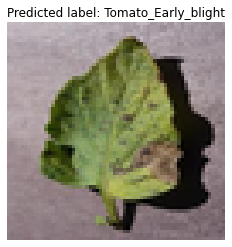

In [52]:
plt.imshow(imgpred)
plt.axis('off')
plt.title("Predicted label: "+labels[itemindex[1][0]])
plt.show()